In [ ]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 18 16:32:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#########################################################################
## MONTAR DRIVE
#########################################################################
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#########################################################################
## CONFIGURAR WANDB
#########################################################################
!pip install wandb
!wandb login

     |████████████████████████████████| 1.8 MB 7.9 MB/s 
     |████████████████████████████████| 145 kB 69.4 MB/s 
     |████████████████████████████████| 181 kB 54.3 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=1694fb30c58bd569ae7f551d7e04062e0c2bdde0765a0e4637ba825b810dda27
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#########################################################################
## CARGAR LAS LIBRERÍAS NECESARIAS
#########################################################################
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from keras.datasets import mnist
import numpy as np

from random import shuffle,seed

import keras
from tensorflow.keras import layers

from keras import metrics
import keras.utils

from skimage.transform import resize

In [ ]:
#########################################################################
## INICIAR WANDB
#########################################################################
import wandb
from wandb.keras import WandbCallback

In [ ]:
##########################################################################
## Variables globales
##########################################################################
num_imagenes=250
epochs = 75
lr = 1e-3
opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
latent_dim=128

In [ ]:
################################################################################################################
## FUNCIÓN PARA CARGAR EL CONJUNTO DE DATOS
###############################################################################################################

# La base de datos MNIST contiene 60000 ejemplos en el conjunto de entrenamiento y 10000 en el conjunto de prueba
# Las imagenes tienen un tamaño 28x28 que redimensionaremos a 28x28x1
def load_data(): 
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
   
    #Cambio el tamaño de las imágenes de 28x28 a 28x28x1
    x_train= x_train.reshape((60000, 28, 28, 1))
    x_test= x_test.reshape((10000, 28, 28, 1))
   
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
   
    #Añadir algo de ruido en el conjunto de prueba
    x_test = np.random.normal(x_test) 
   
    #Normalizamos a escala [0,1] 
    x_train,x_test= x_train / 255,x_test / 255

    return (x_train, y_train), (x_test, y_test)

#Cargamos toda la base de datos MNIST
(x_train, y_train), (x_test, y_test) = load_data()


11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Barajamos el conjunto de datos para no tener clases contiguas y nos quedamos con num_imagenes 

# Declaramos una semilla
seed(123456)

# Guardamos índices
ind_train = list(range(len(x_train)))
ind_test = list(range(len(x_test)))

# Desordenamos los indices para quedarnos con num_imagenes imagenes aleatorias
shuffle(ind_train)
shuffle(ind_test)

# En base a los indices nos quedamos con num_imagenes imágenes
x_train            = x_train[ind_train[0:num_imagenes]]
y_train            = y_train[ind_train[0:num_imagenes]]

x_test             = x_test[ind_test[0:num_imagenes]]
y_test             = y_test[ind_test[0:num_imagenes]]


In [ ]:
################################################################################################################
## CLASE GAN
###############################################################################################################
class GAN(keras.Model):
  # Inicialización del modelo GAN: inicializa el generador,discriminador junto con sus métricas y la dimensión del espacio latente
  def __init__(self, discriminator, generator, latent_dim):
    super().__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
    self.d_loss_metric = keras.metrics.Mean(name="d_loss") 
    self.g_loss_metric = keras.metrics.Mean(name="g_loss")

  # Compilación: se inicializa los optimizadores y la función de pérdida del modelo GAN
  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn 
  
  # Evaluación del Discriminador
  def evaluate_D(self):
    #Generamos las imágenes a partir del espacio latente y el generador
    batch_size = tf.shape(x_train)[0]
    random_latent_vectors = tf.random.normal( shape=(batch_size, self.latent_dim))
    generated_images = self.generator(random_latent_vectors)
    
    #Compilamos el modelo discriminador
    self.discriminator.compile(optimizer=self.d_optimizer,loss=self.loss_fn,metrics=['accuracy'])
    
    #Evaluación del discriminador con las imágenes reales
    loss_real, acc_real = self.discriminator.evaluate(x_test,tf.ones((batch_size, 1),dtype=tf.dtypes.float32), verbose=1)

    #Evaluación del discriminador con las imágenes falsas
    loss_fake, acc_fake = self.discriminator.evaluate(generated_images,tf.zeros((batch_size, 1),dtype=tf.dtypes.float32) , verbose=1)

    # Mostramos por pantalla un resumen 
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    print('>Loss real: ')
    print(loss_real)
    print('>Loss fake: ')
    print(loss_fake)
  
  # Evaluación del Generador
  def evaluate_G(self):
    #Generamos las imágenes a partir del espacio latente y el generador
    batch_size = tf.shape(x_train)[0]
    random_latent_vectors = tf.random.normal( shape=(batch_size, self.latent_dim))
    generated_images = self.generator(random_latent_vectors)

    #Visualizamos varias imágenes generadas seleccionadas de forma aleatoria
    for i in range(9):
        random_latent_vectors = tf.random.normal(
      shape=(9, 128))
        pred = generator(random_latent_vectors )
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(np.squeeze(pred[0]), cmap='gray')
    plt.show()


  # Métricas
  @property
  def metrics(self):
    return [self.d_loss_metric, self.g_loss_metric]

  # Entrenamiento 
  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]
    
    random_latent_vectors = tf.random.normal( shape=(batch_size, self.latent_dim))
    
    generated_images = self.generator(random_latent_vectors)
    combined_images = tf.concat([generated_images, real_images], axis=0)
    labels = tf.concat(
      [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
      axis=0
    )
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    #Entrenamiento del discriminador
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      d_loss = self.loss_fn(labels, predictions)
     
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
      zip(grads, self.discriminator.trainable_weights)
    )

    random_latent_vectors = tf.random.normal(
      shape=(batch_size, self.latent_dim))
    misleading_labels = tf.zeros((batch_size, 1))

    #Entrenamiento del generador
    with tf.GradientTape() as tape:
      predictions = self.discriminator(
        self.generator(random_latent_vectors))
      g_loss = self.loss_fn(misleading_labels, predictions)
      
    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(
      zip(grads, self.generator.trainable_weights))

    
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)
    return {"d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result()}


In [ ]:
################################################################################################################
## Función para mostrar por pantalla 9 imágenes reales, 9 imagenes reales con ruido 
## y 9 imágenes generadas por nuestro modelo generador
###############################################################################################################
def generated_images_plot(original, noised_data, generator):
    """Plot subplot of images during training."""
    print('NOISED')
    for i in range(9):
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(np.squeeze(noised_data[i]), cmap='gray')
    plt.show()
    
    print('GENERATED')
    for i in range(9):
        random_latent_vectors = tf.random.normal(
      shape=(9, 128))
        pred = generator(random_latent_vectors )
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(np.squeeze(pred[0]), cmap='gray')
    plt.show()
    print('ORIGINAL')
    for i in range(9):
        plt.subplot(331 + i)
        plt.axis('off')
        plt.imshow(np.squeeze(original[i]), cmap='gray')
    plt.show()


# EXPERIMENTO 1

**Disriminador**

In [ ]:
discriminator=keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2D(64,kernel_size=3,strides=2,padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator"

)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dropout (Dropout)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1)               

**Generador**

In [ ]:
generator=keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(7*7*128),
        layers.Reshape((7,7,128)),
        layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              809088    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      147584    
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 28, 28, 64)        0 

Compilación, entrenamiento y evaluación de la **GAN**

In [ ]:
wandb.init(project="tfg-silvia-barroso", entity="sail-ugr", 
           config= {
               "learning_rate": lr,
               "epochs": epochs,
               "num_imagenes": num_imagenes,
               "opt": "Adam",
               "latent_dim": latent_dim
               })

#Definición del modelo GAN
gan = GAN(discriminator=discriminator, generator=generator,
        latent_dim=latent_dim)

#Compilación
gan.compile(
    d_optimizer=opt,
    g_optimizer=opt,
    loss_fn=keras.losses.BinaryCrossentropy(),
)

#Entrenamiento
history=gan.fit(
  x_train , epochs=epochs , callbacks=[WandbCallback()]
)
wandb.finish()

wandb: Currently logged in as: ugr-sail (sail-ugr). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/75
8/8 [==============================] - 17s 18ms/step - d_loss: 0.5374 - g_loss: 1.3935 - _timestamp: 1652891638.0000 - _runtime: 28.0000
Epoch 2/75
8/8 [==============================] - 0s 8ms/step - d_loss: 0.1967 - g_loss: 2.4296 - _timestamp: 1652891638.0000 - _runtime: 28.0000
Epoch 3/75
8/8 [==============================] - 0s 9ms/step - d_loss: 0.3777 - g_loss: 2.0059 - _timestamp: 1652891638.0000 - _runtime: 28.0000
Epoch 4/75
8/8 [==============================] - 0s 8ms/step - d_loss: 0.5562 - g_loss: 2.2518 - _timestamp: 1652891638.0000 - _runtime: 28.0000
Epoch 5/75
8/8 [==============================] - 0s 10ms/step - d_loss: 0.9299 - g_loss: 2.6853 - _timestamp: 1652891638.0000 - _runtime: 28.0000
Epoch 6/75
8/8 [==============================] - 0s 8ms/step - d_loss: 0.6657 - g_loss: 1.5822 - _timestamp: 1652891638.0000 - _runtime: 28.0000
Epoch 7/75
8/8 [==============================] - 0s 8ms/step - d_loss: 0.4845 - g_loss: 1.2552 - _timestamp: 1652891638.

d_loss,▆▂▆▇▅▆▆▆▅▅▄█▆▄▆▅▄▆▄▄▄▆▄▄▆▅▃▄▄▅▄▃▂▂▂▂▂▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
g_loss,▁▃▃▂▂▁▅▂▄▂▃▃▂▃▂▃▄▃▄▄▃▃▄▄▂▄▅▄▄▃▃▄▅▅▅▅▆▇██
d_loss,0.06629
epoch,74
g_loss,4.7067


8/8 [==============================] - 0s 3ms/step - loss: 4.2449 - accuracy: 0.0040
>Accuracy real: 9%, fake: 0%
>Loss real: 
3.09079647064209
>Loss fake: 
4.244872093200684


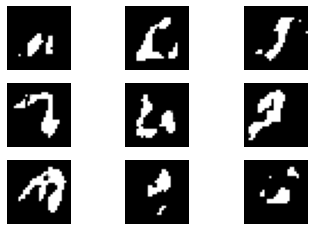

In [ ]:
#Evaluación
gan.evaluate_D()
gan.evaluate_G()

# EXPERIMENTO 2
Vamos a realizar la siguiente mejora para que la pérdida del generador no supere a la pérdida del discriminador y consigan igualarse.  
En el **Discriminador** vamos a hacer una **reducción del learning rate** y un **incremento del dropout**.

In [ ]:
#Optimizador del discriminador donde se ha realizado una reducción del learning rate (Anteriormente se definio la tasa como 1e-3)
opt_d=tf.keras.optimizers.Adam(learning_rate = 1e-9)

In [ ]:
discriminator2=keras.Sequential(
    [
        keras.Input(shape=(28,28,1)),
        layers.Conv2D(64,kernel_size=3,strides=2,padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator2"

)
discriminator2.summary()

Model: "discriminator2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dropout_1 (Dropout)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 1)              

In [ ]:
wandb.init(project="tfg-silvia-barroso", entity="sail-ugr", 
           config= {
               "learning_rate": 1e-09,
               "epochs": epochs,
               "num_imagenes": num_imagenes,
               "opt": "Adam",
               "latent_dim": latent_dim
               })

#Definición del modelo GAN
gan = GAN(discriminator=discriminator2, generator=generator,
        latent_dim=latent_dim)

#Compilación 
gan.compile(
    d_optimizer=opt_d,
    g_optimizer=opt,
    loss_fn=keras.losses.BinaryCrossentropy(),
)

#Entrenamiento
history=gan.fit(
  x_train , epochs=epochs , callbacks=[WandbCallback()]
)

wandb.finish()

Epoch 1/75
8/8 [==============================] - 1s 9ms/step - d_loss: 0.6940 - g_loss: 0.6844 - _timestamp: 1652891653.0000 - _runtime: 4.0000
Epoch 2/75
8/8 [==============================] - 0s 9ms/step - d_loss: 0.6930 - g_loss: 0.6856 - _timestamp: 1652891654.0000 - _runtime: 5.0000
Epoch 3/75
8/8 [==============================] - 0s 9ms/step - d_loss: 0.6939 - g_loss: 0.6868 - _timestamp: 1652891654.0000 - _runtime: 5.0000
Epoch 4/75
8/8 [==============================] - 0s 8ms/step - d_loss: 0.6936 - g_loss: 0.6854 - _timestamp: 1652891654.0000 - _runtime: 5.0000
Epoch 5/75
8/8 [==============================] - 0s 9ms/step - d_loss: 0.6930 - g_loss: 0.6858 - _timestamp: 1652891654.0000 - _runtime: 5.0000
Epoch 6/75
8/8 [==============================] - 0s 8ms/step - d_loss: 0.6935 - g_loss: 0.6861 - _timestamp: 1652891654.0000 - _runtime: 5.0000
Epoch 7/75
8/8 [==============================] - 0s 9ms/step - d_loss: 0.6931 - g_loss: 0.6860 - _timestamp: 1652891654.0000 - _r

d_loss,▅▂▃▃▄▅▆▄▃▄▃▅▆▄▅▅▇▃▃▂▅▁▅▆▃▆▂▂▄▄▅▃▇▅▁▅▆█▄▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
g_loss,▄▆▅▆▄▃▅▅▆▄▄▅▄▆▁▇▄▇█▂▅▃▅▆▄▆▃▄▄▄▆▄▄▂▆▆▄▆▅▂
d_loss,0.69438
epoch,74
g_loss,0.6835


8/8 [==============================] - 0s 3ms/step - loss: 0.6859 - accuracy: 0.7160
>Accuracy real: 30%, fake: 72%
>Loss real: 
0.7008522748947144
>Loss fake: 
0.6859493255615234


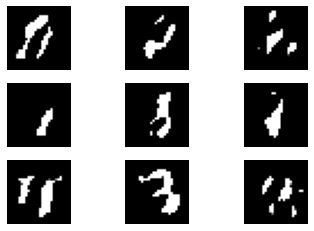

In [ ]:
#Evaluación
gan.evaluate_D()
gan.evaluate_G()

NOISED


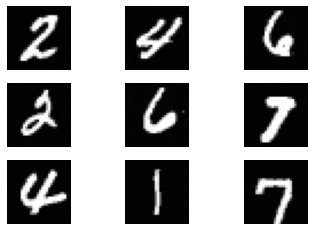

GENERATED


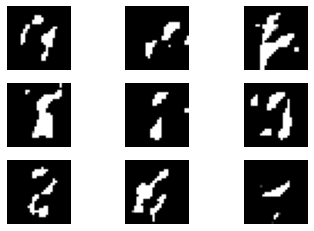

ORIGINAL


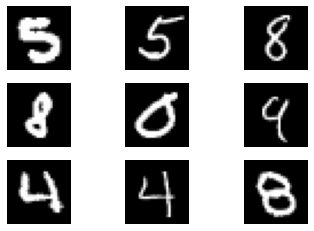

In [ ]:
#Veamos las imágenes generadas por el modelo generador que se ha definido para el EXPERIMENTO 1 y EXPERIMENTO 2
generated_images_plot(x_train, x_test, generator)

# EXPERIMENTO 3
Hemos cambiado la arquitectura del generador y del discriminador para que sea más sotisficada.  

*   En el discriminador se ha incluido más capas de Dropout y se ha utilizado las mejoras citadas en el experimento 2( incrementar dropout y reducir el learning rate). 
*   En el generador se ha implementado una arquitectura más profunda con más capas de convolución y añadiendo capas de BatchNormalization. 

In [ ]:
discriminator3=keras.Sequential(
    [
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(64,kernel_size=3,strides=2,padding="same",activation = 'linear'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.5),
        layers.Conv2D(128, kernel_size=3, strides=2, padding="same",activation = 'linear'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.5),
        layers.Conv2D(256, kernel_size=3, padding="same",activation = 'linear'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator3"

)
discriminator3.summary()

Model: "discriminator3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 256)      

In [ ]:
generator3=keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(28*28*128),
        layers.Reshape((28,28,128)),
        layers.Conv2D(32, kernel_size=3, padding="same",input_shape=(28,28,128)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=3, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=3, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.UpSampling2D((2,2)),
        layers.Conv2D(64, kernel_size=3, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.UpSampling2D((2,2)),
        layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid"),
    ],
    name="generator3",
)
generator3.summary()

Model: "generator3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100352)            12945408  
                                                                 
 reshape_1 (Reshape)         (None, 28, 28, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        36896     
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 28, 28, 32)        0         
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 32)       0         
 ooling2D)                                              

In [ ]:
wandb.init(project="tfg-silvia-barroso", entity="sail-ugr", 
           config= {
               "learning_rate": 1e-09,
               "epochs": epochs,
               "num_imagenes": num_imagenes,
               "opt": "Adam",
               "latent_dim": latent_dim
               })

#Definición del modelo GAN
gan = GAN(discriminator=discriminator3, generator=generator3,
        latent_dim=latent_dim)

#Compilación
gan.compile(
    d_optimizer=opt_d,
    g_optimizer=opt,
    loss_fn=keras.losses.BinaryCrossentropy(),
)

#Entrenamiento 
history=gan.fit(
  x_train , epochs=epochs, callbacks=[WandbCallback()]
)

wandb.finish()

Epoch 1/75
8/8 [==============================] - 2s 27ms/step - d_loss: 0.7009 - g_loss: 0.6725 - _timestamp: 1652891714.0000 - _runtime: 8.0000
Epoch 2/75
8/8 [==============================] - 0s 13ms/step - d_loss: 0.7037 - g_loss: 0.6673 - _timestamp: 1652891714.0000 - _runtime: 8.0000
Epoch 3/75
8/8 [==============================] - 0s 12ms/step - d_loss: 0.7008 - g_loss: 0.6711 - _timestamp: 1652891714.0000 - _runtime: 8.0000
Epoch 4/75
8/8 [==============================] - 0s 12ms/step - d_loss: 0.7041 - g_loss: 0.6668 - _timestamp: 1652891714.0000 - _runtime: 8.0000
Epoch 5/75
8/8 [==============================] - 0s 12ms/step - d_loss: 0.7034 - g_loss: 0.6688 - _timestamp: 1652891714.0000 - _runtime: 8.0000
Epoch 6/75
8/8 [==============================] - 0s 12ms/step - d_loss: 0.6977 - g_loss: 0.6796 - _timestamp: 1652891714.0000 - _runtime: 8.0000
Epoch 7/75
8/8 [==============================] - 0s 13ms/step - d_loss: 0.6957 - g_loss: 0.6821 - _timestamp: 1652891714.00

d_loss,▆██▅▄▄▃▃▃▃▂▂▂▁▁▁▂▂▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
g_loss,▃▁▁▄▅▅▅▇▇▇▇▆▇███▇▇▇▇▇▇██████████████████
d_loss,0.68973
epoch,74
g_loss,0.69315


8/8 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.0000e+00
>Accuracy real: 12%, fake: 0%
>Loss real: 
0.7001887559890747
>Loss fake: 
0.6931505799293518


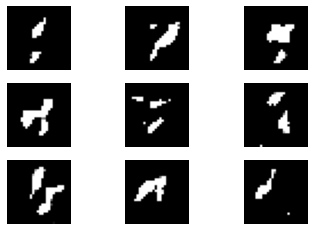

In [ ]:
#Evaluación
gan.evaluate_D()
gan.evaluate_G()

# EXPERIMENTO 4
Vamos a definir nuestro modelo discriminador con una arquitectura que ya vienen preconfiguradas en Keras, llamada MobileNet. 

Esta arquitectura tiene como limitación que acepta imagenes de tamaño minimo 32x32,esto es, el parámetro input_shape de MobileNet no debe ser inferior a 32. Por tanto,tenemos que volver a leer nuestros datos y redimensionarlos de 28x28 a 32x32. 

El generador es un vesión adaptada del generador definido en Experimento 3, de forma que produce imágenes de tamaño 32x32x1

In [ ]:
################################################################################################################
## FUNCIÓN PARA CARGAR EL CONJUNTO DE DATOS Y  REDIMENSIONAR LAS IMAGENES A 32x32x1
###############################################################################################################

# La base de datos MNIST contiene 60000 ejemplos en el conjunto de entrenamiento y 10000 en el conjunto de prueba
# Las imagenes tienen un tamaño 28x28 que redimensionaremos a 32x32x1
def load_data_resize(): 
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
   
    #Primero paso: Redimensiono las imagenes de 28x28 a 32x32
    ret=[]
    ret_test=[]
    for img in x_train:
      ret.append(resize(img,(32,32)))
    for img in x_test:
      ret_test.append(resize(img,(32,32)))

    x_train=np.asarray(ret)
    x_test=np.asarray(ret_test)

    #Segundo paso: Redimensiono las imagenes de 32x32 a 32x32x1
    x_train= x_train.reshape((60000, 32, 32, 1))
    x_test= x_test.reshape((10000, 32, 32, 1))
   
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
   
    #Añadir algo de ruido en el conjunto de prueba
    x_test = np.random.normal(x_test)  
   
    #Normalizamos a escala [0,1]
    x_train,x_test= x_train / 255,x_test / 255

    return (x_train, y_train), (x_test, y_test)

#Cargamos toda la base de datos MNIST redimensionada 
(x_train, y_train), (x_test, y_test) = load_data_resize()


In [ ]:
# Barajamos el conjunto de datos para no tener clases contiguas y nos quedamos con num_imagenes 

# Declaramos una semilla
seed(123456)

# Guardamos índices
ind_train = list(range(len(x_train)))
ind_test = list(range(len(x_test)))

# Desordenamos los indices para quedarnos con num_imagenes imagenes aleatorias
shuffle(ind_train)
shuffle(ind_test)

# En base a los indices nos quedamos con num_imagenes imágenes
x_train            = x_train[ind_train[0:num_imagenes]]
y_train            = y_train[ind_train[0:num_imagenes]]

x_test             = x_test[ind_test[0:num_imagenes]]
y_test             = y_test[ind_test[0:num_imagenes]]

In [ ]:
discriminator4=tf.keras.applications.MobileNet(
    input_shape=(32,32,1), 
    alpha=1.0, 
    depth_multiplier=1,
    dropout=0.5, 
    include_top=False, 
    weights=None,  #Inicialización aleatoria de los pesos
    input_tensor=None, 
    pooling=None,
    classes=2,
    classifier_activation="sigmoid"
)
discriminator4.summary()

Model: "mobilenet_1.00_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        288       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                          

In [ ]:
generator4=keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(32*32*128),
        layers.Reshape((32,32,128)),
        layers.Conv2D(32, kernel_size=3, padding="same",input_shape=(32,32,128)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=3, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=3, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=3, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.UpSampling2D((2,2)),
        layers.Conv2D(64, kernel_size=3, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.UpSampling2D((2,2)),
        layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid"),
        
    ],
    name="generator4",
)
generator4.summary()

Model: "generator4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 131072)            16908288  
                                                                 
 reshape_2 (Reshape)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        36896     
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 average_pooling2d_2 (Averag  (None, 16, 16, 32)       0         
 ePooling2D)                                            

In [ ]:
wandb.init(project="tfg-silvia-barroso", entity="sail-ugr", 
           config= {
               "learning_rate": 1e-09,
               "epochs": epochs,
               "num_imagenes": num_imagenes,
               "opt": "Adam",
               "latent_dim": latent_dim
               })

#Definicion del modelo GAN
gan = GAN(discriminator=discriminator4, generator=generator4,
        latent_dim=latent_dim)

#Compilación
gan.compile(
    d_optimizer=opt_d,
    g_optimizer=opt,
    loss_fn=keras.losses.BinaryCrossentropy(),
)

#Entrenamiento
history=gan.fit(
  x_train , epochs=epochs, callbacks=[WandbCallback()]
)

wandb.finish()

Epoch 1/75
8/8 [==============================] - 5s 78ms/step - d_loss: 8.0858 - g_loss: 0.0000e+00 - _timestamp: 1652891810.0000 - _runtime: 11.0000
Epoch 2/75
8/8 [==============================] - 0s 31ms/step - d_loss: 8.0881 - g_loss: 0.0000e+00 - _timestamp: 1652891810.0000 - _runtime: 11.0000
Epoch 3/75
8/8 [==============================] - 0s 31ms/step - d_loss: 8.0910 - g_loss: 0.0000e+00 - _timestamp: 1652891810.0000 - _runtime: 11.0000
Epoch 4/75
8/8 [==============================] - 0s 33ms/step - d_loss: 8.0922 - g_loss: 0.0000e+00 - _timestamp: 1652891810.0000 - _runtime: 11.0000
Epoch 5/75
8/8 [==============================] - 0s 31ms/step - d_loss: 8.0852 - g_loss: 0.0000e+00 - _timestamp: 1652891811.0000 - _runtime: 12.0000
Epoch 6/75
8/8 [==============================] - 0s 52ms/step - d_loss: 8.1144 - g_loss: 0.0000e+00 - _timestamp: 1652891811.0000 - _runtime: 12.0000
Epoch 7/75
8/8 [==============================] - 0s 40ms/step - d_loss: 8.1017 - g_loss: 0.00

d_loss,▃▃▄█▄▆▄▅▄█▆▅▄▅▅▆▅▅▅▅▅▇▇▄▅▄▅▅▆▄▄▄▅▁▇▄▃▁▅▅
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
g_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
d_loss,8.10105
epoch,74
g_loss,0.0


8/8 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Accuracy real: 0%, fake: 0%
>Loss real: 
15.424948692321777
>Loss fake: 
0.0


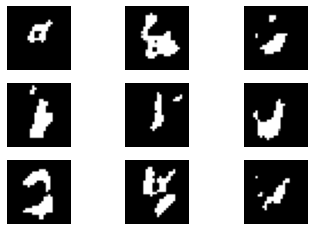

In [ ]:
#Evaluación
gan.evaluate_D()
gan.evaluate_G()